In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import abtem
import dask
import os

#setting configuration
#abtem.config.set({"device": "gpu", "fft": "fftw"})
#dask.config.set({"num_workers": 1})

In [2]:
import importlib
import helper_funcs
importlib.reload(helper_funcs)

<module 'helper_funcs' from '/home/torchuser/data/evamaria/hBN_sim/testing/helper_funcs.py'>

In [3]:
#df = pd.read_csv('./data/data_overview.csv')
#df.head()
#extract chosen data
#df1 = df.loc[df['defect_atom_symbol'] == 'O'] #single value: df_parameters.at[1,'timestamp']

### RAW

In [4]:
#CHOOSE - which data?
data_dir = '../data/raw_no_abberations_numconfig20/'

data1 = '20240913224628_hBN_size20x13_single_vacancyN_filledwithB_energy60000_defocus0_Cs-100000_astig0_astigangle0_coma0_RAW.zarr'
#data2 = '20240912170055_hBN_size20x13_single_vacancyB_filledwithC_energy60000_defocus0_Cs-100000_astig0_astigangle0_coma0_RAW.zarr'
data3 = '20240913142026_hBN_size20x13_single_vacancyN_filledwithC_energy60000_defocus0_Cs-100000_astig0_astigangle0_coma0_RAW.zarr'

#data_list = [data1, data2, data3]
data_list = [data1, data3]

In [5]:
#import preparation
data_names = data_list
measurements_list = [None] * len(data_names)
#sort by timestamp
data_names.sort()

#fill measurements_list with imported data
for i in range(len(data_names)):
    path = f'{data_dir}{data_names[i]}'
    measurements_list[i] = abtem.from_zarr(path).compute()

[########################################] | 100% Completed | 1.33 sms
[########################################] | 100% Completed | 1.35 sms


In [6]:
len(measurements_list)
data_names[0]

'20240913142026_hBN_size20x13_single_vacancyN_filledwithC_energy60000_defocus0_Cs-100000_astig0_astigangle0_coma0_RAW.zarr'

In [7]:
#extract parameter information --> see data_names[0] for correct indices
#parameter_info = ["_".join([string.split('_')[0], (string.split('_')[7]).lstrip('filledwith')]) for string in data_names[:]]
#parameter_info = [string.split('_')[7] for string in data_names[:]]
parameter_info = ["_".join([string.split('_')[4], string.split('_')[5]]) for string in data_names[:]]

parameter_info

['vacancyN_filledwithC', 'vacancyN_filledwithB']

(20.0, 30.0)

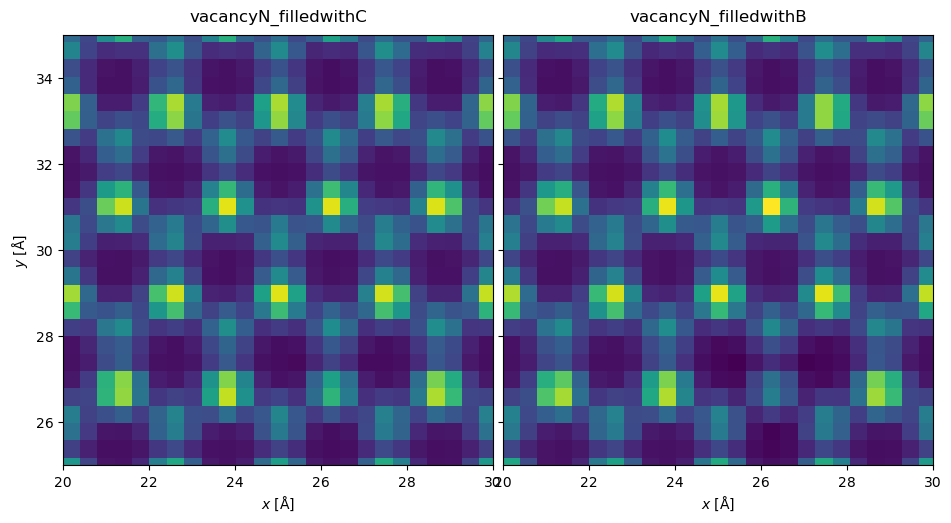

In [8]:
#plot
measurements = abtem.stack([m for m in measurements_list], parameter_info)
measurements[::].show(figsize=(14, 5), explode=True, cbar=False,common_color_scale=True)

plt.ylim(25,35)
plt.xlim(20,30)

In [9]:
#line_profiles_raw = measurements.interpolate_line_at_position(center=(23.9, 28.1), angle=0, extent=10)

In [10]:
#line_profiles_raw[::5].show(explode=False, legend=True)

### INTERPOLATED + GAUSS

In [11]:
#set parameters for postprocessing
#pairs: interpolate:0.01 & gauss: 0.2;  interpolate:0.05 & gauss: 0.3
#interpolate-> higher value (0.1) more pixels; low value -> smoother, more time
interpolate = 0.01
gauss = 0.3
dose = 1e9

In [12]:
#interpolate to smooth images and apply gaussian filter to consider partial spatial coherence 
final_measurements = measurements.interpolate(interpolate).gaussian_filter(gauss)

(20.0, 30.0)

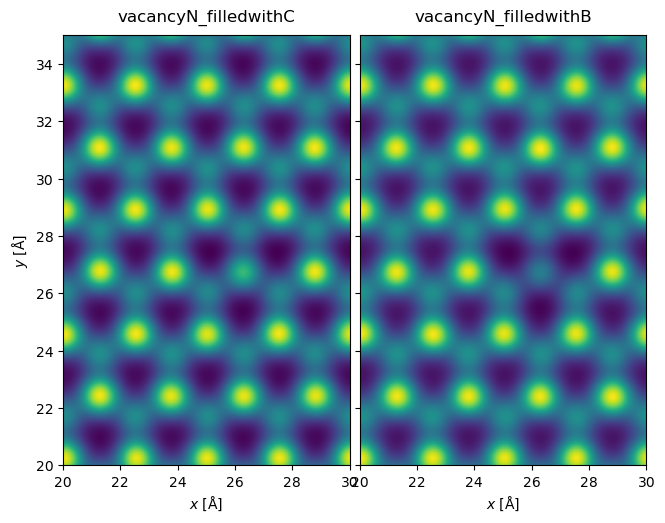

In [13]:
#plot
final_measurements_plot = abtem.stack(final_measurements, parameter_info)
final_measurements_plot[:].show(explode=True, figsize=(14, 5), cbar=False, common_color_scale=False)

plt.ylim(20,35)
plt.xlim(20,30)

In [14]:
#set parameters
center_x = 26.4#23.8 #23.8
center_y = 27.5#28.2
extent = 14
lattice_constant = 2.504
angle = 0

#preparation for plot of line profile with angle=30 degree
x_angle = np.cos(angle * np.pi/180)*extent/2
y_angle = np.sin(angle * np.pi/180)*extent/2

IndexError: tuple index out of range

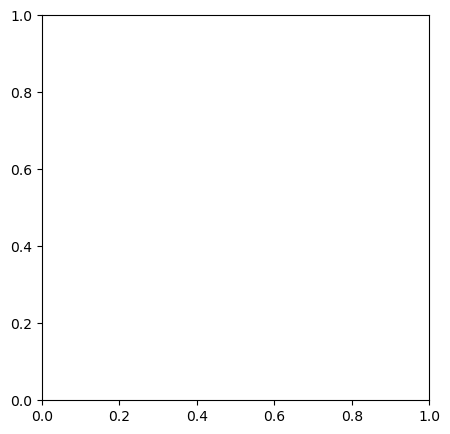

In [15]:
fig_ang0, ax = plt.subplots(figsize=(5,5))
final_measurements_plot[2].show(ax=ax, explode=False, figsize=(14, 5), cbar=False, common_color_scale=False)

line_ang0 = lines.Line2D([center_x - extent/2, center_x + extent/2,], [center_y, center_y], color='red')
line_ang0_y = lines.Line2D([center_x, center_x,], [center_y - extent/2, center_y + extent/2], color='red')

ax.add_line(line_ang0)
ax.add_line(line_ang0_y)

line_ang = lines.Line2D([center_x - x_angle, center_x + x_angle], [center_y - y_angle, center_y + y_angle], color='red')

ax.add_line(line_ang)

plt.ylim(24,30)
plt.xlim(23,30)

In [ ]:
line_profiles = final_measurements.interpolate_line_at_position(center=(center_x, center_y), angle=angle, extent=extent)


In [ ]:
line_start = line_profiles.metadata.get('start')
line_end = line_profiles.metadata.get('end')
   

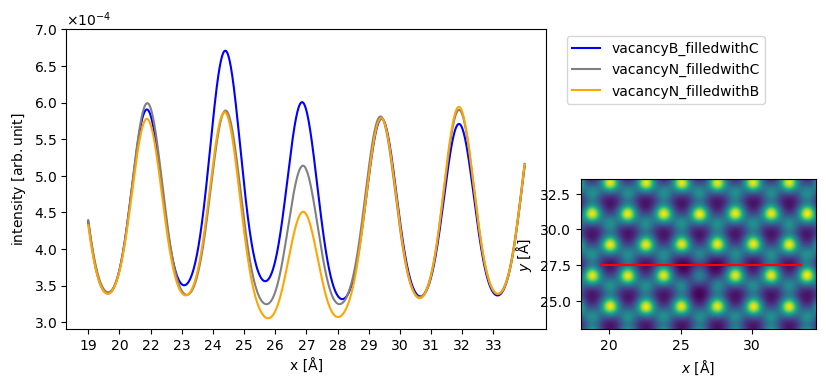

In [43]:
#plot settings - single plot
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5))
ax1.set_position([0.64, 0, 0.3, 0.3])#[x,y, width,height] -> all values [0:1]
ax2.set_position([0, 0, 0.6, 0.6])
ax1.set_zorder(3)#holt kleinen plot in den Vordergrund
ax2.set_zorder(1)
x_ticks = [i for i in range(extent)]
x_labels = np.around(np.linspace(line_start[0], line_end[0], extent),0).astype(int)
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_labels)

#ax1.set_facecolor('khaki')

#atomic structure with line corresponding to line profiles
final_measurements_plot[2].show(ax=ax1, explode=False, figsize=(14, 5), cbar=False, common_color_scale=False)
line_ang = lines.Line2D([center_x - x_angle, center_x + x_angle], [center_y - y_angle, center_y + y_angle], color='red')
ax1.add_line(line_ang)
ax1.set_xlim(18,34.5)
ax1.set_ylim(23,33.5)

#mainplot: line profiles
color_list = ['blue', 'grey', 'orange']
for i in range(len(data_names)):
    
    line_profiles[i].show(ax=ax2, color=color_list[i], label=parameter_info[i])

ax2.legend(loc='upper right', bbox_to_anchor=(1.47, 1))
ax2.set_xlabel('x [Å]')
ax2.set_ylim(0.00029, 0.0007)

if line_start > line_end:
    ax2.invert_xaxis()

#fig.figure.savefig('./data_phonons/numconfigs_ang0_without_defect.png', bbox_inches='tight')

### alles zusammen

In [17]:
#look at minima
extent_small = 2
center1 = (22.5,27.5)
center2 = (25.5,27.5)

line_min1 = final_measurements.interpolate_line_at_position(center=center1, angle=angle, extent=extent_small)
line_min2 = final_measurements.interpolate_line_at_position(center=center2, angle=angle, extent=extent_small)


In [18]:
min1a, min1b = line_min1[0].min(), line_min1[1].min()
min2a, min2b = line_min2[0].min(), line_min2[1].min()

minima_y = [min1a, min1b, min2a, min2b]

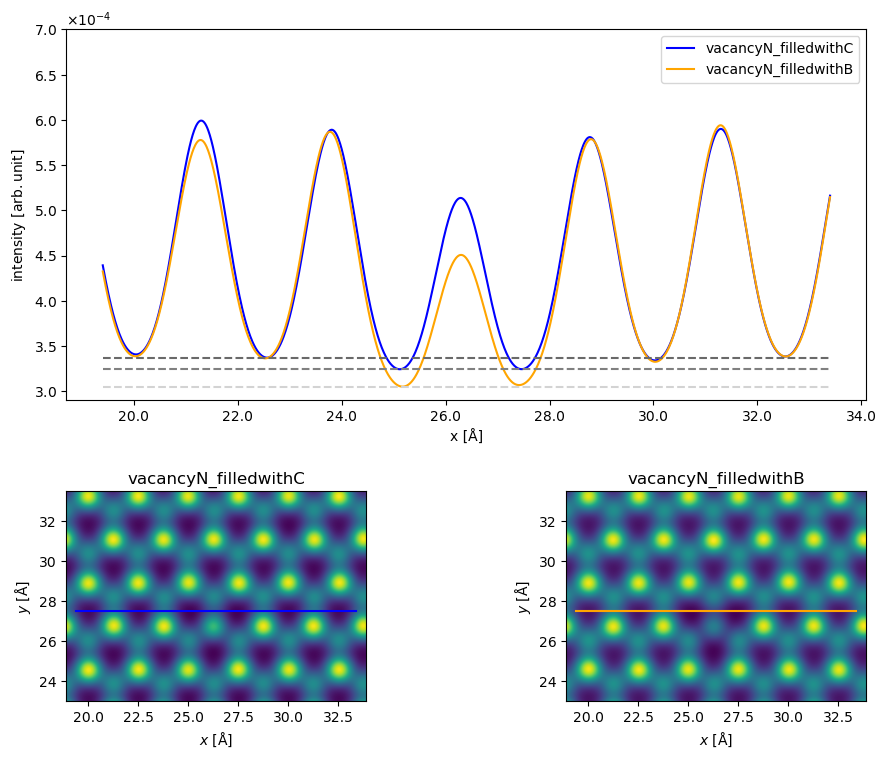

In [20]:
#mainplot
#set parameters
center_x = 26.4 #

center_y_list = [27.5, 27.5, 27.5,] #
angle_list = [0, 0, 0,]#each entry in the angle_list must correspond to a value in the center_y_list
color_list = ['blue', 'orange', 'orange', 'limegreen', 'magenta', 'yellow']

extent = 14
lattice_constant = 2.504
columns = len(data_names)
subplot_x_size = 10 
subplot_y_size = 7
column_indices_wanted = [0,1,]



#plot prep
fig, axs = plt.subplots(2, columns, figsize=(subplot_x_size,subplot_y_size))

#surpress unused axes
for i in range(columns):
    if i > 0:   
        axs[0,i].set_visible(False)

not_wanted = [i for i in range(len(data_names)) if i not in column_indices_wanted]
for plot in not_wanted:
    axs[1, plot].set_visible(False)

#plot
for col in column_indices_wanted:
    #create line profiles
    center_y = center_y_list[col]
    angle = angle_list[col]
    
    line_profiles = final_measurements.interpolate_line_at_position(center=(center_x, center_y), angle=angle, extent=extent)
    line_start = line_profiles.metadata.get('start')
    line_end = line_profiles.metadata.get('end')
    
    #preparation for plot of line profile with angle (degree)
    x_angle = np.cos(angle * np.pi/180)*extent/2
    y_angle = np.sin(angle * np.pi/180)*extent/2

    #plot settings: ax assignment & positioning
    ax1 = axs[1, col]
    ax2 = axs[0, 0]
    traveling_x = (subplot_x_size*(col+1) - subplot_x_size)/(subplot_x_size*columns)
    ax1.set_position([traveling_x, 0, 0.3, 0.3])#[x,y, width,height] -> all values [0:1]
    ax2.set_position([0, (subplot_y_size*0.43)/subplot_y_size, 0.8, 0.53])

    #atomic structure with line corresponding to line profiles
    final_measurements_plot[col].show(ax=ax1, explode=False, figsize=(14, 5), cbar=False, common_color_scale=False)
    line_ang = lines.Line2D([center_x - x_angle, center_x + x_angle], [center_y - y_angle, center_y + y_angle], color=color_list[col])
    ax1.add_line(line_ang)
    ax1.set_xlim(center_x - extent/2 - 0.5, center_x + extent/2 + 0.5)
    ax1.set_title(parameter_info[col])
    ax1.set_ylim(23,33.5)
    
    #mainplot: line profiles
    line_profiles[col].show(ax=ax2, color=color_list[col], label=parameter_info[col])
    
    #sometimes line profile is drawn from right to left. For easier understanding -> we invert image.
    if line_start > line_end:
        ax2.invert_xaxis()
        

#plot settings
ax_main = axs[0,0]
ax_main.legend(loc='upper right', )#bbox_to_anchor=(1.3, 1))
ax_main.set_xlabel('x [Å]')
x_ticks = np.arange(0, extent+1, step=2)
x_labels = np.around(np.linspace(line_start[0], line_end[0], len(x_ticks)),1)
tick_shift = 0.6
ax_main.set_xticks(x_ticks+tick_shift)
ax_main.set_xticklabels(x_labels+tick_shift)
ax_main.set_ylim(2.9e-4, 7e-4)
x_values = np.linspace(0, extent, 200)
y_values = [0.0003244719 for i in range(len(x_values))] #0.00030523894 or 0.0003244719 or 0.00033727323
y_values2 = [0.00030523894 for i in range(len(x_values))] #0.00030523894 or 0.0003244719
y_values3 = [0.00033727323 for i in range(len(x_values))] #0.00030523894 or 0.0003244719


ax_main.plot(x_values, y_values, linestyle = 'dashed', color = 'grey' )
ax_main.plot(x_values, y_values2, linestyle = 'dashed', color = 'lightgrey' )
ax_main.plot(x_values, y_values3, linestyle = 'dashed', color = 'dimgrey'  )


#fig.figure.savefig('./images/CvsB_filling_lineprofiles1.png', bbox_inches='tight')

### Müll

In [257]:
#access lineprofile_array!!
test = line_min1.get_items([0])#['array'])
test1 = test.get('array')
test1[0][:3]
len(test1)

1

In [263]:
#access lineprofile_array!!
test = [1,2,3]
test2 = [1,2,4]

mask = np.array([test[i] == test2[i] for i in range(len(test))])
#mask = np.array(test < 1)
print(mask)
mask.nonzero()

[ True  True False]


(array([0, 1]),)

In [268]:
#how to access lineprofile_array
y_vals1a = (line_min1.get_items([0]).get('array'))
y_vals1b = (line_min1.get_items([1]).get('array'))
y_vals2a = (line_min1.get_items([0]).get('array'))
y_vals2b = (line_min1.get_items([1]).get('array'))


#mask = np.array([test[i] == test2[i] for i in range(len(test))])
#mask = np.array(test < 1)

#mask

In [294]:
print(minima_y)

[0.00033727323, 0.00033653458, 0.0003244719, 0.00030523894]


In [284]:
min1a, min1b = line_min1[0].min(), line_min1[1].min()
min2a, min2b = line_min2[0].min(), line_min2[1].min()

minima_y = [min1a, min1b, min2a, min2b]
y_vals = [y_vals1a, y_vals1b, y_vals2a, y_vals2b]
line_list = [line_min1, line_min1, line_min2, line_min2]
min_coordinates = [None] * len(minima_y)


for i in range(len(minima_y)):
    min_now = minima_y[i]
    index_min = int(np.array([value == min_now for value in y_vals[i]]).nonzero()[1])
    #print(index_min)
    start_now = line_list[i].metadata.get('start')
    end_now = line_list[i].metadata.get('end')
    value_number = len(y_vals[i][0])
    x_values = [np.linspace(start_now, end_now, value_number)]
    print(len(x_values))
    print(y_vals[i][0].shape)
    #min_coordinates[i] = (x_values[index_min], min_now)

    


1
(1401,)
1
(1401,)
1
(1401,)
1
(1401,)


/tmp/ipykernel_28335/839266424.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index_min = int(np.array([value == min_now for value in y_vals[i]]).nonzero()[1])


### NOISE

In [199]:
#noise to account for finite electrone dose -> statistic deviation (see abtem walkthrough -> scan & detect)
#noisy_measurements = final_measurements.poisson_noise(dose_per_area=dose, seed=100)


In [ ]:
noisy_measurements_plot = abtem.stack(noisy_measurements, parameter_info)
noisy_measurements_plot[::5].show(explode=True, figsize=(12, 4))
